### Image classification using Food-101 dataset

Task description:

Grab the dataset from https://huggingface.co/datasets/food101

Implement a convolutional neural network for multiclass image classification.

In [1]:
import torch
import numpy as np
import torchvision 
from torchvision import transforms 
import pyarrow.parquet as pq
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from IPython.display import display

In [2]:
def read_parquet(file):
    desired_size = (28, 28)
    table = pq.read_table(file)
    image_bytes = table.column('image').to_pylist()
    labels_in = table.column('label').to_pylist()

    transform = transforms.Compose([
        transforms.Resize(desired_size),
        transforms.ToTensor()
    ])

    images = []
    labels = []
    for i,img_bytes in enumerate(image_bytes):
        image = Image.open(io.BytesIO(img_bytes['bytes']))
        image = transform(image)
        if image.size() == torch.Size([3, 28, 28]):
            labels.append(labels_in[i])
            images.append(image)
    train_labels = torch.tensor(labels)
    train_images = torch.stack(images)
    return TensorDataset(train_images, train_labels)

In [3]:
train_dataset = read_parquet("food101_part.parquet")

In [8]:
test_dataset = read_parquet("food101_part_1.parquet")

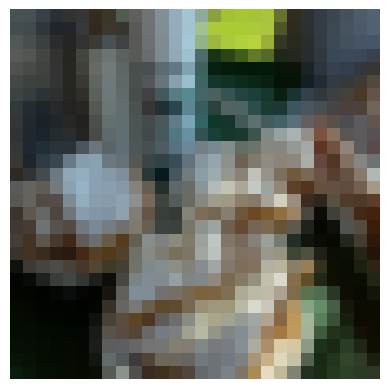

In [9]:
import matplotlib.pyplot as plt
import numpy as np
img_tensor = train_dataset[30][0]
img_np = img_tensor.numpy().transpose(1, 2, 0)
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [10]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(test_dataset, batch_size, shuffle=False)

In [11]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 3, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [12]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 3, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [13]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 101)) 

In [14]:
device = torch.device("cpu")

model = model.to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.1509 val_accuracy: 0.0000
Epoch 2 accuracy: 0.2672 val_accuracy: 0.0070
Epoch 3 accuracy: 0.3209 val_accuracy: 0.0090
Epoch 4 accuracy: 0.3668 val_accuracy: 0.0139
Epoch 5 accuracy: 0.4119 val_accuracy: 0.0054
Epoch 6 accuracy: 0.4500 val_accuracy: 0.0053
Epoch 7 accuracy: 0.4845 val_accuracy: 0.0095
Epoch 8 accuracy: 0.5215 val_accuracy: 0.0104
Epoch 9 accuracy: 0.5569 val_accuracy: 0.0104
Epoch 10 accuracy: 0.5876 val_accuracy: 0.0113


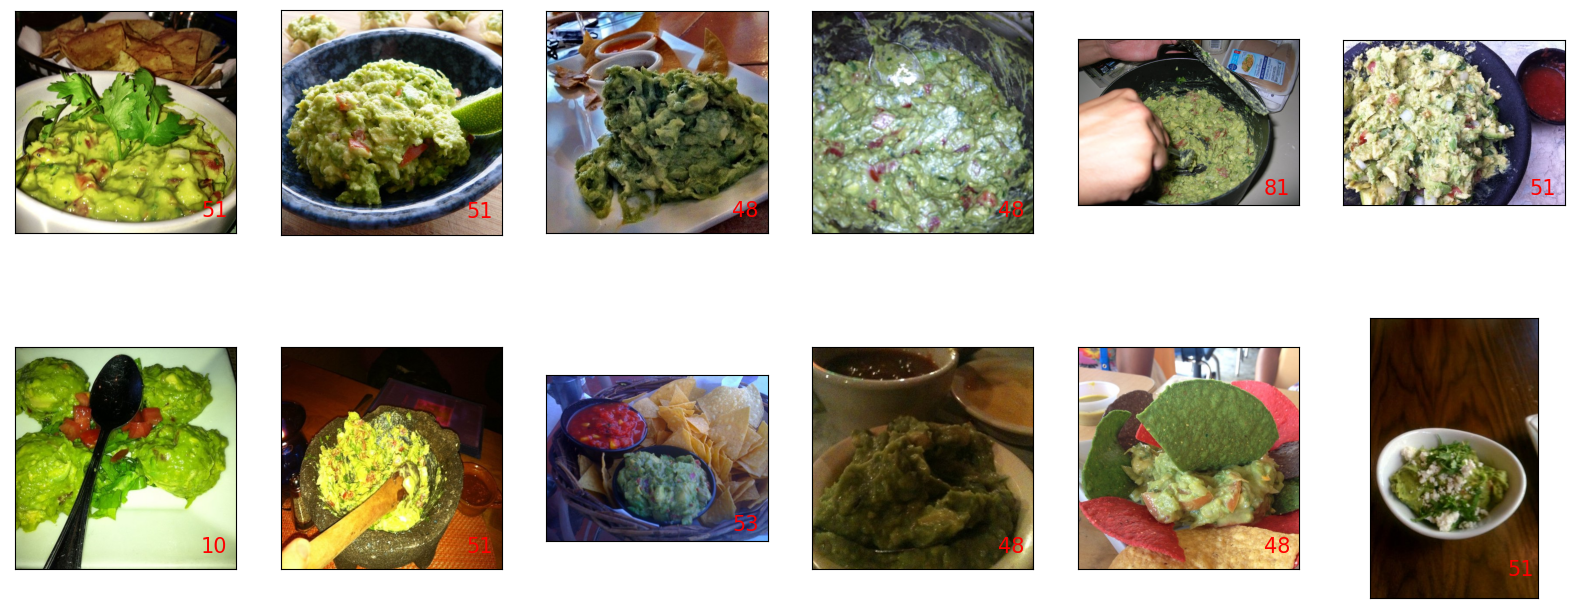

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
table = pq.read_table("food101_part_1.parquet")
image_bytes = table.column('image').to_pylist()
labels_in = table.column('label').to_pylist()

transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

fig = plt.figure(figsize=(20, 8))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img_bytes = image_bytes[i]
    img = Image.open(io.BytesIO(img_bytes['bytes']))
    img = transform(img)
    pred = model(img.unsqueeze(0))
    y_pred = torch.argmax(pred)
    
    img = Image.open(io.BytesIO(img_bytes['bytes']))
    ax.imshow(img)  
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
plt.show()

In [17]:
labels_in[:12]

[51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51]